# Random Forest 

- sklearn
- pca
- kfolds cross-validation
- added weights for class imbalance
- roc_auc and balanced log loss
- hyperparameter tuning using grid search 
- *grid search vs randomized search: While grid search looks at every possible combination of hyperparameters to find the best model, random search only selects and tests a random combination of hyperparameters.*

**QUESTIONS**

- Why am I getting a negative loss?
- I thought that random forest were a good alternative because they didn't need pruning, but then the training data always fits to 1

**TO-DO**

- "Some inputs do not have OOB scores"
- Predicting 
- Check which variables make up the components in PCA

In [1]:
# Data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Modelling
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, log_loss
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split, learning_curve, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from scipy.stats import randint
from sklearn.metrics import get_scorer_names
from random import randint #so that randomizedsearchcv will work
from yellowbrick.model_selection import ValidationCurve


# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


# Data loading and preprocessing

In [2]:
os.chdir('/Users/ecompu/Library/CloudStorage/OneDrive-Personal/Berkeley/W207_Machine_Learning/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/icr-identify-age-related-conditions/')

dataset = pd.read_csv('train.csv')

In [3]:
# label as integer
label = "Class"

classes = dataset[label].unique().tolist()
print(f"Label classes: {classes}")

dataset[label] = dataset[label].map(classes.index)

Label classes: [1, 0]


In [4]:
#convert EJ to dummy for PCA
ej_dummy = pd.get_dummies(
    dataset['EJ'],prefix='EJ', dtype=int)

dataset = pd.concat(
    [dataset,ej_dummy],
    axis=1
)

#drop ID and EJ
dataset = dataset.drop(['Id','EJ'], axis=1)

In [5]:
# outcome 
y = dataset['Class'].values

# features 
X = dataset[[i for i in dataset.columns if i not in ['Class']]].values

# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,
                                   test_size=0.20, random_state=42)

# train and test dataframes 
train_df = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

test_df = pd.concat(
    [pd.DataFrame(y_test), pd.DataFrame(X_test)],
    axis=1
)

# rename columns
train_df.columns=['Class','AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC',
                  'BD ', 'BN', 'BP','BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF',
                  'CH', 'CL', 'CR', 'CS', 'CU','CW ', 'DA', 'DE', 'DF', 'DH',
                  'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH',
                  'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR','FS',
                  'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'EJ_A', 'EJ_B']

# assign names to test_df
test_df.columns = train_df.columns

In [6]:
# Find which columns have missing values
sum_null = train_df.isnull().sum()
sum_null[sum_null!=0]


#sum_null = test_df.isnull().sum()
#sum_null[sum_null!=0]

BQ    53
CC     1
DU     1
EL    52
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [7]:
mean_values = train_df.mean()
filled_df = train_df.fillna(mean_values, inplace=False)
train_df = filled_df

sum_null = train_df.isnull().sum()
sum_null[sum_null!=0]

Series([], dtype: int64)

In [8]:
mean_values = train_df.mean()
filled_df = test_df.fillna(mean_values, inplace=False)
test_df = filled_df

sum_null = test_df.isnull().sum()
sum_null[sum_null!=0]

Series([], dtype: int64)

In [9]:
# X_train, y_train, X_test, y_test
columns = [i for i in dataset.columns if i not in ['Class']]

y_train = train_df[label].values
y_test = test_df[label].values

X_train = train_df[columns].values
X_test = test_df[columns].values


# # Check the shape of the train and test sets
print('Shape X_train: ', X_train.shape, '\nShape X_test: ', X_test.shape,
      '\nShape y_train: ', y_train.shape,'\nShape y_test:', y_test.shape)

Shape X_train:  (493, 57) 
Shape X_test:  (124, 57) 
Shape y_train:  (493,) 
Shape y_test: (124,)


In [10]:
# standardize the features 
sc = StandardScaler()
sc.fit(X_train)
print("Mean: ", sc.mean_, '\nVariance: ', sc.var_)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Mean:  [4.79408065e-01 3.48842872e+03 1.20109105e+02 3.96546256e+01
 1.01366201e+01 5.57687527e+00 4.32556765e-02 1.06155017e+01
 8.61046896e+00 5.33541169e+03 2.13041775e+01 2.37967980e+02
 9.73198871e+01 8.38425571e+02 5.58099270e+02 7.54783843e+01
 6.89034076e-01 8.92425934e+01 1.13429701e+01 3.04857505e-02
 1.41004116e+00 7.37949417e-01 3.72373689e+01 1.38056490e+00
 2.68568421e+01 5.17830781e+01 4.07236890e+02 6.27078231e-01
 3.67998727e-01 1.44943725e+02 9.37269523e+01 2.62775699e+01
 1.96632068e+00 1.93401814e+00 2.70723956e+01 8.95177970e+00
 3.11456074e+00 1.77171174e+03 3.40765704e-01 6.92161222e+01
 1.05060731e+02 5.38209932e+01 7.17676694e+01 7.91497237e+00
 1.03600018e+04 1.01896790e+01 5.67828977e+00 4.05571176e+00
 4.40755389e-01 2.06484588e+01 1.21559504e+02 1.51913293e+04
 3.16263867e+01 4.87226794e+01 8.41205176e+00 3.52941176e-01
 6.47058824e-01] 
Variance:  [2.40280512e-01 5.61870782e+06 1.91104610e+04 5.41832867e+03
 1.32946004e+02 6.80633789e+00 3.07880647e-03 1.9

Feature Extraction using PCA

In [11]:
pca = PCA(n_components=56)  
pca.fit(X_train_std)

# Rename the columns
columns = []
for i in range(pca.n_components):
    columns.append('PCA{}'.format(i + 1))

X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

Number of principal components explaining 95% of variance: 39


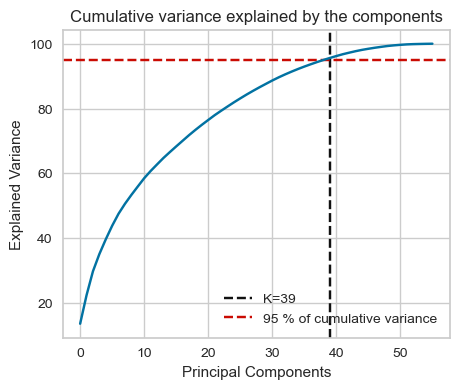

In [12]:
# find cumulative variance
var_cum = np.cumsum(pca.explained_variance_ratio_)*100
 
# how many principal components explain 95% of the variance?
k = np.argmax(var_cum>95)
print("Number of principal components explaining 95% of variance: "+ str(k))
 
plt.figure(figsize=[5,4])
plt.title('Cumulative variance explained by the components')
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.axvline(x=k, color="k", linestyle="--", label = "K=39")
plt.axhline(y=95, color="r", linestyle="--", label="95 % of cumulative variance")
ax = plt.plot(var_cum)
              
plt.legend()

In [13]:
# rerun again with 39 components
pca = PCA(n_components=39) 
pca.fit(X_train)

# Rename the columns
columns = []
for i in range(pca.n_components):
    columns.append('PCA{}'.format(i + 1))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [14]:
# remake train and test dfs with pcas
train_df_pca = pd.concat(
    [pd.DataFrame(X_train_pca, columns=columns),pd.DataFrame(y_train, columns=['Class'])],
    axis=1
)

test_df_pca = pd.concat(
    [pd.DataFrame(X_test_pca, columns=columns),pd.DataFrame(y_test, columns=['Class'])],
    axis=1
)

print(type(train_df_pca),type(test_df_pca))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


# Build the model

In [34]:
# Weight the classes
neg, pos = np.bincount(train_df_pca['Class'])
total = neg + pos

# weight_for_0 = (neg/total)*100/
# weight_for_1 = (pos/total)*100


weight_for_0 = (1 / neg) * (total / 2.0)  #from kaggle
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 2.90
Weight for class 1: 0.60


# Fit the model

In [30]:
rf = RandomForestClassifier(class_weight=class_weight,oob_score=True,random_state=42,criterion='entropy')

In [31]:
#fitting without gridsearch
rf.fit(X_train_pca, y_train)

RandomForestClassifier(class_weight={0: 17.24137931034483,
                                     1: 82.75862068965517},
                       criterion='entropy', oob_score=True, random_state=42)

In [18]:
# out-of-bag error
oob_error = 1 - rf.oob_score_
print(f'OOB error: {oob_error:.3f}')


OOB error: 0.162


2. I used `cross_validate` to report roc_auc and balanced log loss

$$\log \text { Loss }=\frac{-\frac{1}{N_0} \sum_{i=1}^{N_0} y_{0 i} \log p_{0 i}-\frac{1}{N_1} \sum_{i=1}^{N_1} y_{1 i} \log p_{1 i}}{2}$$

- {N_c} is the number of observations of class (c)
- \log is the natural logarithm
- y_{c i}is 1 if observation (i) belongs to class (c) and 0 otherwise
- p_{c i} is the predicted probability that observation (i) belongs to class (c).

The submitted probabilities for a given row are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, each predicted probability 𝑝
 is replaced with max(min(𝑝,1−10−15),10−15).

In [19]:
#get_scorer_names() # Since balanced_log_loss isn't available, we have to define it and call it with make_scorer

# Suggestions

- decision trees take neg of loglikelihood, 
- remove the minus in front 
- problem with hyperparameters 
- try to balance data from beg and use typical loss. (downsample)
- check data types 
- say "we tried this, investigated and couldn't figure out what we did"

https://stackoverflow.com/questions/59260861/why-is-my-loss-function-return-negative-values

In [37]:
def balanced_log_loss(y_true, y_pred):
    N0 = np.sum(y_true == 0) #num observations class 0
    N1 = np.sum(y_true == 1) #num observations class 1

    p0 = y_pred[y_true == 0] #pred_prob class 0
    p1 = y_pred[y_true == 1] #pred_prob class 0

    y0 = y_true[y_true == 0] #ground truth class 0
    y1 = y_true[y_true == 1] #ground truth class 1

    # log_loss_0 = -np.sum(y0 * np.log(np.clip(p0, 1e-15, 1.0))) / N0 if N0 > 0 else 0 #balanced log loss class 0, adjust for edge cases
    # log_loss_1 = -np.sum(y1 * np.log(np.clip(p1, 1e-15, 1.0))) / N1 if N1 > 0 else 0 #balanced log loss class 1, adjust for edge cases 

    log_loss_0 = np.sum(y0 * np.log(np.clip(p0, 1e-15, 1.0))) / N0 if N0 > 0 else 0 #balanced log loss class 0, adjust for edge cases
    log_loss_1 = np.sum(y1 * np.log(np.clip(p1, 1e-15, 1.0))) / N1 if N1 > 0 else 0 #balanced log loss class 1, adjust for edge cases 

    return (log_loss_0 + log_loss_1) / 2

# Evaluate the model



In [38]:
balanced_log_loss_scorer = make_scorer(balanced_log_loss, greater_is_better=False)

scoring = {
    'roc_auc': 'roc_auc',
    'balanced_log_loss': balanced_log_loss_scorer
}

scores = cross_validate(rf, X_train_pca, y_train, n_jobs=-1, cv=10, scoring=scoring, return_train_score=True)
sorted(scores.keys())

# Training and validation balanced Log Loss
print("Training balanced log loss. Mean: %0.2f, Standard deviation: %0.2f" % (scores['train_balanced_log_loss'].mean(),scores['train_balanced_log_loss'].std()))
print("Validation balanced log loss. Mean: %0.2f Standard deviation: %0.2f" % (scores['test_balanced_log_loss'].mean(),scores['test_balanced_log_loss'].std()))

print("-"*50)
# Training and validation average roc_auc
print("Training balanced roc_auc. Mean: %0.2f, Standard deviation: %0.2f" % (scores['train_roc_auc'].mean(),scores['train_roc_auc'].std()))
print("Validation balanced roc_auc. Mean: %0.2f Standard deviation: %0.2f" % (scores['test_roc_auc'].mean(),scores['test_roc_auc'].std()))



Training balanced log loss. Mean: 0.00, Standard deviation: 0.00
Validation balanced log loss. Mean: 0.42 Standard deviation: 0.33
--------------------------------------------------
Training balanced roc_auc. Mean: 1.00, Standard deviation: 0.00
Validation balanced roc_auc. Mean: 0.87 Standard deviation: 0.07


Plot curves

- Note: training looks "perfect" because samples take the same paths through the trees when training and predicting, so of course a near perfect fit is obtained. That is why out-of-bag training accuracy/error is used.

- So, this code where I plot fold vs. score is kind of funny

- Also, why is my log loss negative? 

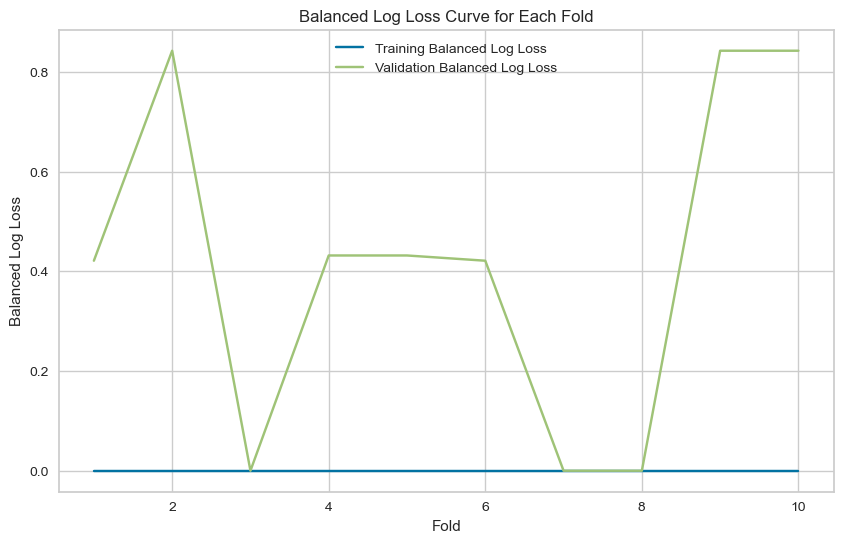

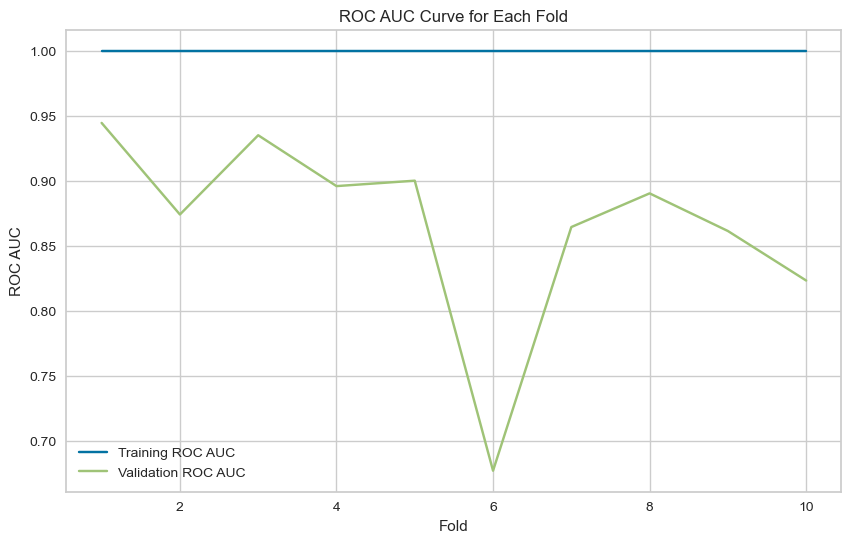

In [39]:
# Plotting roc_auc and balanced log loss for each fols

train_balanced_log_loss = scores['train_balanced_log_loss']
val_balanced_log_loss = scores['test_balanced_log_loss']
train_roc_auc = scores['train_roc_auc']
val_roc_auc = scores['test_roc_auc']

# Get the number of folds
num_folds = len(train_balanced_log_loss)

# Create an array with the fold numbers (1 to num_folds)
fold_numbers = np.arange(1, num_folds + 1)

# Plot balanced log loss curves
plt.figure(figsize=(10, 6))
plt.plot(fold_numbers, train_balanced_log_loss, label='Training Balanced Log Loss')
plt.plot(fold_numbers, val_balanced_log_loss, label='Validation Balanced Log Loss')
plt.xlabel('Fold')
plt.ylabel('Balanced Log Loss')
plt.title('Balanced Log Loss Curve for Each Fold')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC AUC curves
plt.figure(figsize=(10, 6))
plt.plot(fold_numbers, train_roc_auc, label='Training ROC AUC')
plt.plot(fold_numbers, val_roc_auc, label='Validation ROC AUC')
plt.xlabel('Fold')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Curve for Each Fold')
plt.legend()
plt.grid(True)
plt.show()

Evaluating the influence of a single hyperparameter

/Users/ecompu/opt/anaconda3/envs/w207_final/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ecompu/opt/anaconda3/envs/w207_final/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ecompu/opt/anaconda3/envs/w207_final/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ecompu/opt/anaconda3/envs/w207_final/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ecompu/op

KeyboardInterrupt: 

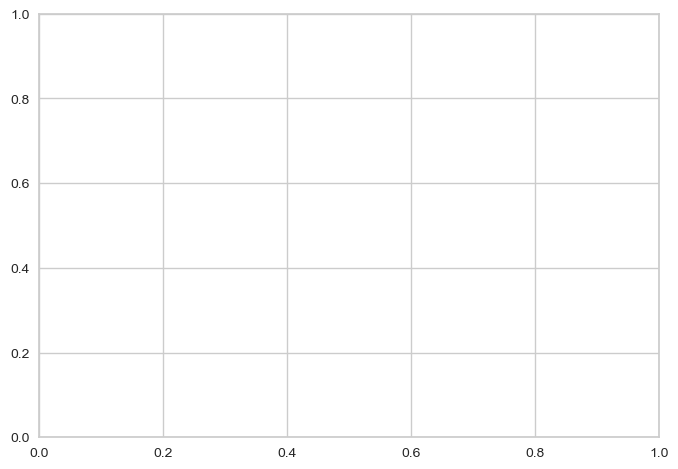

In [23]:
# note: x axis is number of folds
viz = ValidationCurve(rf, param_name="n_estimators", n_jobs=-1,
     param_range=np.arange(1, 300), cv=10, scoring="roc_auc")

viz.fit(X_train_pca, y_train)
viz.show()

Vizualize a sample tree

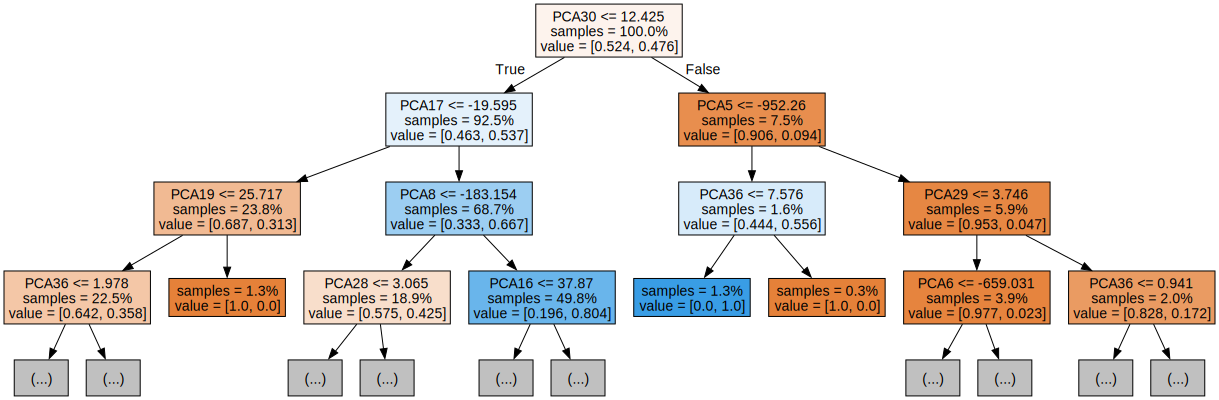

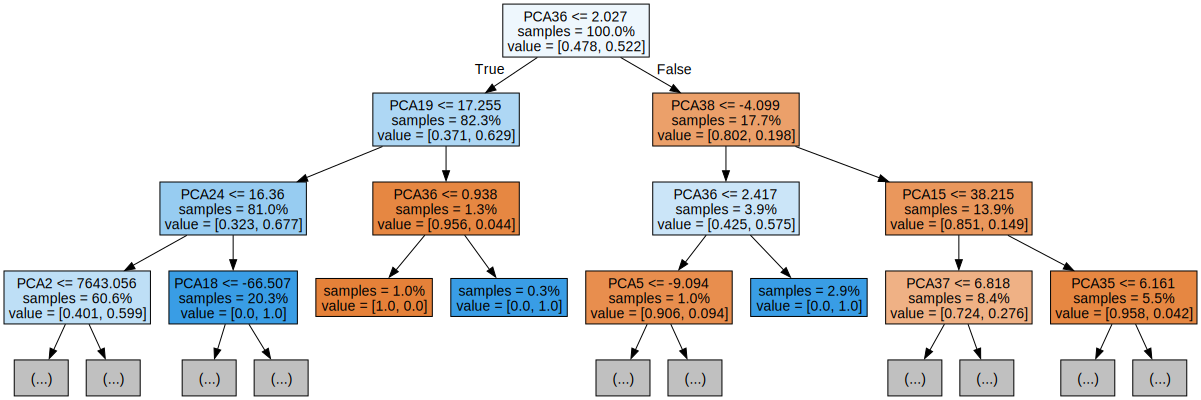

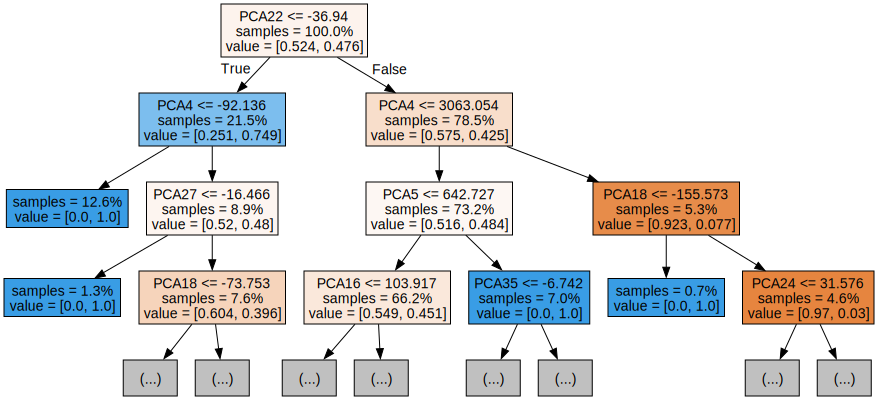

In [82]:
# Export the first n (change in range) decision trees from the forest
columns = [i for i in train_df_pca.columns if i not in ['Class']]


for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=columns,
                               filled=True,
                               max_depth=3, #show depth of tree. If None, shows full tree
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Fit the best model to whole training set after k-fold cross-validation

# Hyperparameter tuning

In [84]:
#hyperparameter tuning: 
hyperparameter_space = {'n_estimators': [100,200, 300,400,5000], #number of trees default=100
                         'max_depth': [3, 6, 9]} #depth of trees


scoring_metrics = {
    'roc_auc': 'roc_auc',
    'balanced_log_loss': balanced_log_loss_scorer
}

# GridSearchCV for ROC AUC
gs_roc_auc = GridSearchCV(rf, param_grid=hyperparameter_space, cv=10, n_jobs=-1, scoring='roc_auc', refit='roc_auc')
gs_roc_auc.fit(X_train_pca, y_train)

# GridSearchCV for balanced log loss
gs_balanced_log_loss = GridSearchCV(rf, param_grid=hyperparameter_space, cv=10, n_jobs=-1, scoring=make_scorer(balanced_log_loss, greater_is_better=False), refit='balanced_log_loss')
gs_balanced_log_loss.fit(X_train_pca, y_train)

# Access the best models for each metric
best_model_roc_auc = gs_roc_auc.best_estimator_
best_model_balanced_log_loss = gs_balanced_log_loss.best_estimator_

# Access the best hyperparameters for each metric
best_params_roc_auc = gs_roc_auc.best_params_
best_params_balanced_log_loss = gs_balanced_log_loss.best_params_

In [87]:
print("Best model for roc_auc: ", best_model_roc_auc)
print("Best model for balanced log loss: ", best_model_balanced_log_loss)

print("Optimal hyperparameter combination for roc_auc: ", best_params_roc_auc)
print("Optimal hyperparameter combination for balanced log loss: ", best_params_balanced_log_loss)

Best model for roc_auc:  RandomForestClassifier(class_weight={0: 2.9, 1: 0.6041666666666666},
                       criterion='entropy', max_depth=9, n_estimators=400,
                       oob_score=True, random_state=42)
Best model for balanced log loss:  RandomForestClassifier(class_weight={0: 2.9, 1: 0.6041666666666666},
                       criterion='entropy', max_depth=9, n_estimators=200,
                       oob_score=True, random_state=42)
Optimal hyperparameter combination for roc_auc:  {'max_depth': 9, 'n_estimators': 400}
Optimal hyperparameter combination for balanced log loss:  {'max_depth': 9, 'n_estimators': 200}


# Fit best model

In [88]:
best_model = RandomForestClassifier(class_weight={0: 2.9, 1: 0.6041666666666666},
                       criterion='entropy', max_depth=9, n_estimators=400,
                       oob_score=True, random_state=42)

best_model.fit(X_train_pca, y_train)

RandomForestClassifier(class_weight={0: 2.9, 1: 0.6041666666666666},
                       criterion='entropy', max_depth=9, n_estimators=400,
                       oob_score=True, random_state=42)

# Evaluate best model

In [89]:
balanced_log_loss_scorer = make_scorer(balanced_log_loss, greater_is_better=False)

scoring = {
    'roc_auc': 'roc_auc',
    'balanced_log_loss': balanced_log_loss_scorer
}

scores = cross_validate(best_model, X_train_pca, y_train, n_jobs=-1, cv=10, scoring=scoring, return_train_score=True)
sorted(scores.keys())

# Training and validation balanced Log Loss
print("Training balanced log loss. Mean: %0.2f, Standard deviation: %0.2f" % (scores['train_balanced_log_loss'].mean(),scores['train_balanced_log_loss'].std()))
print("Validation balanced log loss. Mean: %0.2f Standard deviation: %0.2f" % (scores['test_balanced_log_loss'].mean(),scores['test_balanced_log_loss'].std()))

print("-"*50)
# Training and validation average roc_auc
print("Training balanced roc_auc. Mean: %0.2f, Standard deviation: %0.2f" % (scores['train_roc_auc'].mean(),scores['train_roc_auc'].std()))
print("Validation balanced roc_auc. Mean: %0.2f Standard deviation: %0.2f" % (scores['test_roc_auc'].mean(),scores['test_roc_auc'].std()))

Training balanced log loss. Mean: 0.00, Standard deviation: 0.00
Validation balanced log loss. Mean: -0.09 Standard deviation: 0.17
--------------------------------------------------
Training balanced roc_auc. Mean: 1.00, Standard deviation: 0.00
Validation balanced roc_auc. Mean: 0.89 Standard deviation: 0.06


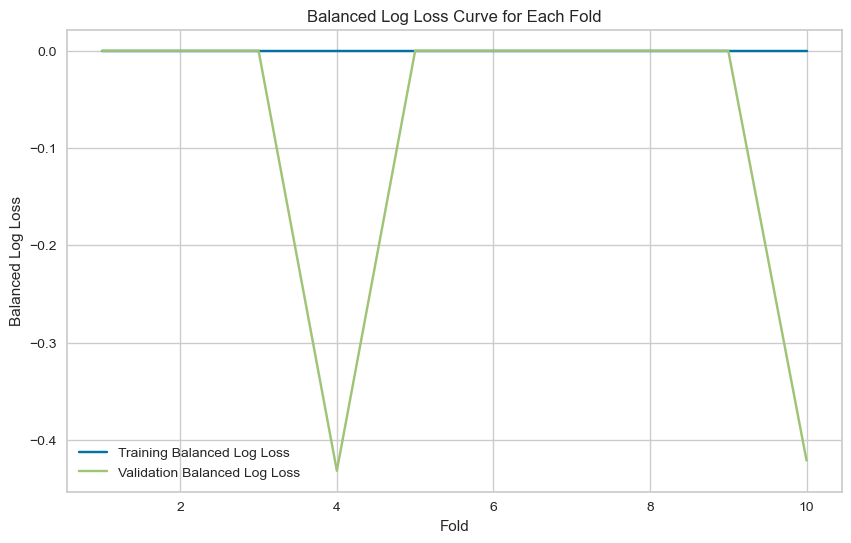

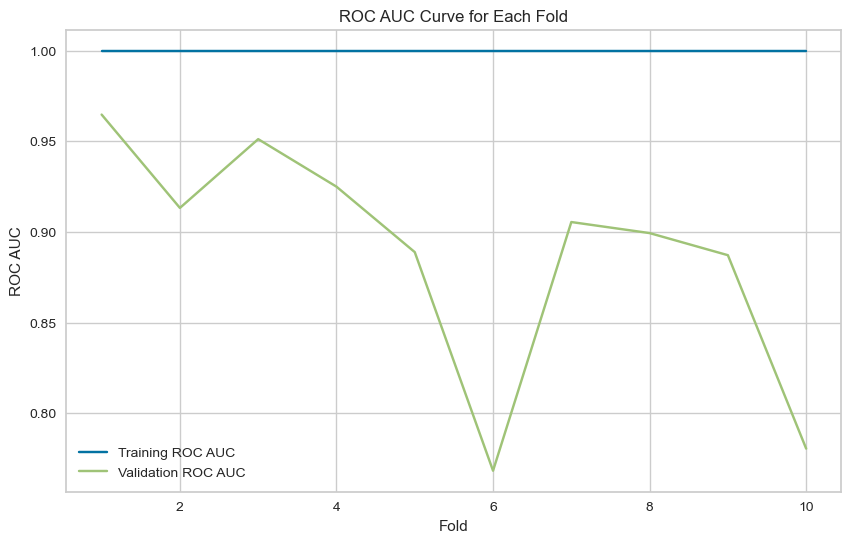

In [90]:
train_balanced_log_loss = scores['train_balanced_log_loss']
val_balanced_log_loss = scores['test_balanced_log_loss']
train_roc_auc = scores['train_roc_auc']
val_roc_auc = scores['test_roc_auc']

# Get the number of folds
num_folds = len(train_balanced_log_loss)

# Create an array with the fold numbers (1 to num_folds)
fold_numbers = np.arange(1, num_folds + 1)

# Plot balanced log loss curves
plt.figure(figsize=(10, 6))
plt.plot(fold_numbers, train_balanced_log_loss, label='Training Balanced Log Loss')
plt.plot(fold_numbers, val_balanced_log_loss, label='Validation Balanced Log Loss')
plt.xlabel('Fold')
plt.ylabel('Balanced Log Loss')
plt.title('Balanced Log Loss Curve for Each Fold')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC AUC curves
plt.figure(figsize=(10, 6))
plt.plot(fold_numbers, train_roc_auc, label='Training ROC AUC')
plt.plot(fold_numbers, val_roc_auc, label='Validation ROC AUC')
plt.xlabel('Fold')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Curve for Each Fold')
plt.legend()
plt.grid(True)
plt.show()

/Users/ecompu/opt/anaconda3/envs/w207_final/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ecompu/opt/anaconda3/envs/w207_final/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ecompu/opt/anaconda3/envs/w207_final/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ecompu/opt/anaconda3/envs/w207_final/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/ecompu/op

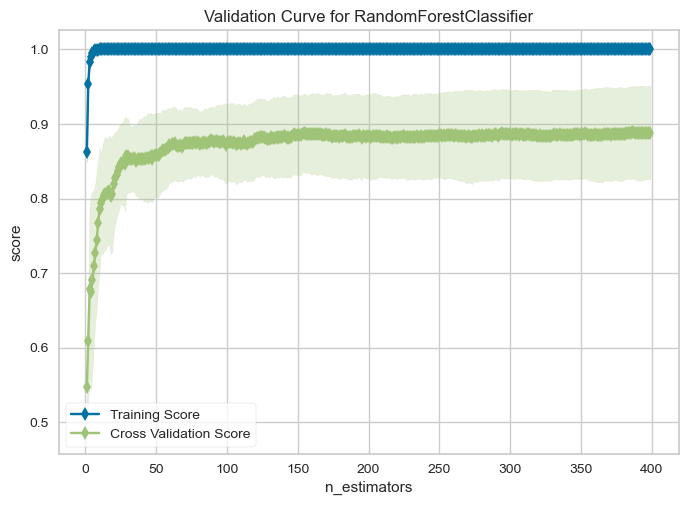

<Axes: title={'center': 'Validation Curve for RandomForestClassifier'}, xlabel='n_estimators', ylabel='score'>

In [91]:
# note: x axis is number of folds
viz = ValidationCurve(best_model, param_name="n_estimators", n_jobs=-1,
     param_range=np.arange(1, 400), cv=10, scoring="roc_auc")

viz.fit(X_train_pca, y_train)
viz.show()

**THOUGHTS FOR THE ANALYSIS**


"That's by construction of the decision trees in the RF: (at least by default) the trees are not pruned. Thus roughly 2/3 (more precisely, approximately 1 - 1/e) of the trees will contain the training case and can look up the correct solution. Even if the 1/e trees which were not trained with this case would always predict wrongly, they'd always be outvoted."

Conclusion: for RF, only oob error i.e. using only those trees that were not trained on the case or validation/verification with proper unknown cases are relevant.

The decision tree corresponding to sample 1 never sees those oob observations during the training process. So, this set of oob observations can be used as a* validation set for that decision tree. We can evaluate the entire ensemble by averaging out the oob evaluations of each decision tree. **This is called the out-of-bag evaluation which is an alternative to cross-validation.**

ChatGPT on why I'm getting negative log-losses: 

Negative balanced log losses are possible when the predicted probabilities (y_pred) for some samples are very close to 1 for the correct class. In the balanced log loss calculation, you have a term of the form -y_true * log(p), where y_true is the ground truth label (0 or 1), and p is the predicted probability for that sample belonging to the correct class. When p is close to 1 and y_true is 1, this term becomes very close to zero. However, since you have a negative sign in front of it, it makes the overall log loss negative.

To better understand this, let's consider an example. Assume that for a specific sample, the ground truth is y_true = 1, and the predicted probability for class 1 is p1 = 0.999. Now, if you calculate the log loss term for this sample, it would be:

- y_true * log(p1) = -1 * log(0.999) = -0.001.

So, you can see that the log loss term is close to zero but negative due to the negative sign in front of it.

This is not necessarily an issue with your code, but it highlights the behavior of the log loss function when dealing with extremely confident predictions.

Regarding the mean balanced log loss being exactly zero for the training set, it means that your model is making perfect predictions on the training data, and the predicted probabilities are almost always exactly 1 or 0 for each sample, resulting in near-zero balanced log losses.

However, having a negative mean balanced log loss on the validation set may indicate that the model is overfitting. It's essential to investigate further and potentially adjust your model to avoid overfitting. Regularization techniques or adjusting the model's complexity might help improve the validation performance. Additionally, it's always a good idea to check the cross-validation results with different folds or a different dataset to ensure the robustness of the findings.